# The N-armed bandit problems

Let's look at a famous reinforcement learning problem called the N-armed bandit problem. A client in a casino, has access to several levers, each one yielding money with a different distribution of probabilities. Given that the client has no prior knowledge of these distributions, he must tries each lever several times before he can infer which one is best. Of course, this involves a tradeoff between trying a lever whose payoff is uncertain (a.k.a exploring) and repeatedly using the lever that yields the highest return in average.

This seemingly simple problem is a classic in the machine learning field and many nontrivial algorithm were devised to find an operational solution to it. Inspiration for the examples below example was drawn from *Reinforcement Learning:
An Introduction*, a book by Richard S. Sutton and Andrew G. Barto, which is also available as [html](http://webdocs.cs.ualberta.ca/~sutton/book/the-book.html)

Here, I consider only two very simple strategies, namely Monte-Carlo simulations and an $\epsilon$-greedy strategy. Their performance is assessed by running a large number of simulations for each of them. The programming challenge will be to write a Python program whose computation time does not increase to fast so as to make this comparison feasible. Luckily, Python has many available options to optimize optimize. We will use this learning exercise to review two of them: vectorization and Just-In-Time copmilation.

[This notebook was initially conceived as an interactive exercise for the Workshop on High Performance Computing that took place before the CEF 2014 conference in [Oslo](http://comp-econ.org/CEF_2014/Oslo). Each bullet point was meant as a question to solve by participant. You can download the initial exercise without the answers from here : [give link].

## Try it yourself !

If you run this notebook on your computer, and if you drop the `n_armed_bandit_game.py`, in the same directory as the notebook, you can try to play the N-armed bandit game yourself.

Click each button in turn and try to maximize the total discounted value. The value reported next to each button $i$ is the average of the past payoffs for bandit $i$.

In [2]:
from n_armed_bandit_game import HumanPlayer
hp = HumanPlayer(5)
hp.display()

## Definition of the problem

Let's define the problem more formally.

Take N random distributions $\left(d(n)\right)_{n\in[1,N]}$. Each distribution is called an arm of the machine.

The Player faces a machine with $N$ arms. Each arm $n\in[1,N]$ gives a stochastic payoff $d(n)$ which is i.i.d.

The distribution of the rewards is unknown but at each date $t\in [1,T]$ the player can take an action $n$ and get the stochastic payoff $d(n)$.

His goal is to choose a series of actions $(a_t)_{0\leq t \leq T}$  at each time to maximize intertemporal utility $\sum_{0 \leq t \leq T} \beta^t U(d_{a_t})$ with $0<\beta<1$ and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma>1$.

The player doesn't know the distributions of reward of each arm 


## Objective

The goal of this tutorial is to implement simple learning strategy. 
- a stupid Monte-Carlo strategy
- an $\epsilon$ greedy strategy where the optimal action is selected with probability $1-\epsilon$ while a random action is taken with probability $\epsilon$

Each strategy will be given $K=1000$ different randomly drawn games to play, each of them being a $T=10000$ periods learning episode. Then we will average over the $K$ experiments to see which is the best strategy. In particular, we want to find the value of $\epsilon$ that yields the optimal exploration/exploitation tradeoff for our distribution of problems.

# Coding the problem

We will assume that the $d(n)$ are normally distributed with standard deviation $1$. The means $(m_n)$ of these distribution are a permutation of the equally distributed points $\left(\frac{n-1}{N-1}\right)_{n\in[1,N]}$.

In [2]:
from numpy import *

In [3]:
# we choose the parameters:

T = 1000
K = 10000

N = 5        # number of arms
beta = 0.95   # discount factor
gamma = 0.5   # risk aversion

- draw an instance of the problem as two one-dimensional arrays of size N, `means` and `deviations`

In [3]:
# response 1


# Finding the Best Arm with Monte-Carlo simulations (and use vectorized computations)

Here we consider a very simple strategy: 
- Given an integer $T_1$. During $N T_1$ periods, we use each lever in turn in order to estimate the lever that yields the higher utility.
- Then, until last date $T$, we us the lever for which expected utility is higher.

In [5]:
T1 = 10

This algorithm can be expressed in a way that doesn't require any conditional operation. The first and the second step can be expressed as a series of array operations. 

----
- create an array `'rewards'` of size $N \times T_1$ such that each line $n$ contains $T_1$ realizations of the distribution $d(n)$

----
- estimate the mean utility procured by each arm and select the best arm

array([ 0.78126682,  1.32556455,  1.4223774 ,  0.49238937,  1.01025611])

----
- compute the estimated mean of each distribution and the discounted value of playing each arm in turn during $N T_1$ periods.

----
- compute the value of the strategy

To profile the efficiency of these computations, the easiest way consists in encapsulate them in a function and profile this functions using IPython's `prun` magic.

----
- encapsulate the algorithm as a function and profile it (use ipython magic `%prun -s time`)

In [12]:
semi_monte_carlo(beta, T, 100, means, deviations) 

[0.56510584443015477, 1.0870655863145628, 14.169619748693677, True]

In [13]:
exps = [semi_monte_carlo(beta, T, 100, means, deviations) for i in range(K)]

In [14]:
%prun -s time all_values = array([semi_monte_carlo(beta, T, 100, means, deviations) for i in range(K)])

Note that we invode the `prun` command with option `-s time` so that functions taking more computation time, appear first. The first lines show something like:
```
   21004 function calls in 1.612 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    1.249    0.001    1.582    0.002 <ipython-input-13-645b3a1ee348>:1(semi_monte_carlo)
     1000    0.149    0.000    0.149    0.000 {method 'rand' of 'mtrand.RandomState' objects}
     1000    0.094    0.000    0.102    0.000 function_base.py:8(linspace)
        1    0.030    0.030    1.612    1.612 <string>:1(<module>)
     1000    0.027    0.000    0.027    0.000 {numpy.core._dotblas.dot}
```
Appart from the generation of random numbers by the rand method, it looks like most of the time is spent in the vector operations in the `semi_monte_carlo` method. Since these are presumed to be very efficient, there doesn't seem to be much room for improvement.

NOTE: there actually *is* room for improvements. From an algorithmic perspective, the procedure could be vectorized across all experiments. Also, vectorized operations using `numpy` arrays are much better than interpreted loops but they don't make efficiently use of CPU and memory resources. `numexpr` and `theano` are two libraries that seek to optimize this kind of vector operations. I leave it as an exercise for the reader, or for a later post.

----

- Find the optimal number of periods to spend on monte-carlo evaluations

In [15]:
def average_payoff(T1, K):
    
    vals = []
    for k in range(K):
        [means, deviations] = new_problem(N)
        res =  semi_monte_carlo(beta,T, T1, means, deviations)
        vals.append(res)
        
    return array(vals).mean(axis=0)

In [16]:
T1_vec = range(0,15)
AP_array = array([average_payoff(T1, K) for T1 in T1_vec])

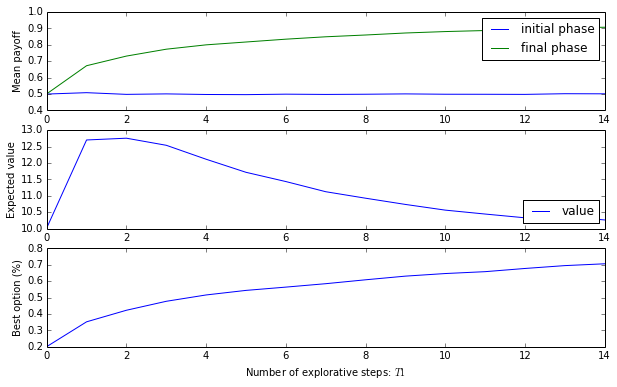

In [17]:
from matplotlib.pyplot import *
%matplotlib inline
figure(figsize=(10,6))

subplot(311)
plot(T1_vec, AP_array[:,0], label='initial phase')
plot(T1_vec, AP_array[:,1], label='final phase')
legend()
ylabel("Mean payoff")

subplot(312)
plot(T1_vec, AP_array[:,2], label='value')
legend(loc='lower right')
ylabel("Expected value")

subplot(313)
plot(T1_vec, AP_array[:,3])
xlabel("Number of explorative steps: $T1$")
ylabel("Best option (%)")




The first panel of the above graph show that explorative steps have a constant payoff over time, equal to 0.5. This is because it treats all levers symetrically. However, more explorative steps, increases in expectation the payoff of the final phase because it produces more information about which is the optimal lever to triger. The lower panel is consistent with this observation: it shows that the best button is selected more often when more explorative steps are taken.vec

Of course, the as soon as some information is known about the better levers, exploration becomes more costly because it implies underoptimal payoffs. For this reason, there is an optimal number of exploration steps to take, before the greedy approach becomes optimal. In the parametrization that we use, the optimal choice is $T1=2$, meaning that each trigger is triggered two times exactly, before the agent selects the higher yielding one.

# $\epsilon$-greedy strategies

We now consider a more elaborate strategy. Like in the former algorithm, we maintain a guess for the expected reward of each arm.
But at each step we choose between "exploiting" the best option or "exploring" another one at random.

Here is the definition of the algorithm. At each step:

At each step: 
- take an action
 - with probability $1-\epsilon$, choose the arm that is believed to have higher return (greedy option)
 - with probability $\epsilon$ take another arm at random    
- Update the expection of the chosen option.



----
- implement the epsilon-greedy algorithm

In [18]:
def pick(means, deviations, a):
    
    return numpy.random.randn()*deviations[a] + means[a]


from numba import jit

def play(beta, T, means, deviations, epsilon=0.1):
    
    '''
    T:        number periods
    means:    variances of the problem
    estimate: 
    '''
    
    N = len(means)
    average_reward = 0
    value = 0
    best = 0
    
    discount = 1
        
    estimate = numpy.ones(N)*0.5
    
    for t in range(T):
        
        greedy = numpy.random.rand()>epsilon
        
        if greedy:
            action = best
            
        else:
            action = numpy.random.randint(N)
            
        rew = pick(means, deviations, action)
        
        estimate[action] =  (estimate[action]*(t) + rew)/(t+1)
            
        best = numpy.argmax(estimate)
    
        value += rew*discount
        
        discount *= beta
        
    return value

----
- compute the average return over $K$ experiments for $\epsilon=0.01$

In [19]:
%time array( [  play(beta, T, means, deviations, 0.01) for n in range(K) ] ).mean()

CPU times: user 56.2 s, sys: 82.1 ms, total: 56.3 s
Wall time: 56.4 s


14.656126325240169

Aouch, this naive approach took approximately one minute to complete... But we can certainly do better. As we did before, we will try to locate bottlenecks by profiling the code.

----
- profile using prun

In [20]:
%prun -s time values = array( [  play(beta, T, means, deviations, 0.01) for n in range(K) ] )

The output of the profiler is something like:
    
```
         50160319 function calls in 67.440 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000   41.060    0.004   67.412    0.007 <ipython-input-131-7bcf9468a19b>:8(play)
 10000000   12.652    0.000   15.191    0.000 <ipython-input-131-7bcf9468a19b>:1(pick)
 10000000    5.408    0.000    5.408    0.000 {method 'argmax' of 'numpy.ndarray' objects}
 10000000    3.722    0.000    9.130    0.000 fromnumeric.py:878(argmax)
 10000000    2.539    0.000    2.539    0.000 {method 'randn' of 'mtrand.RandomState' objects}
 10000000    1.794    0.000    1.794    0.000 {method 'rand' of 'mtrand.RandomState' objects}
    10001    0.114    0.000    0.114    0.000 {range}
    10000    0.048    0.000    0.048    0.000 {numpy.core.multiarray.copyto}
```
    
Here is how we can decode these timings:
- 41 seconds are spent in the play function (excluding calls to functions) in doing  basic operations. This is something that we can certainly reduce a lot by compiling the corresponding code with Numba.
- 13 seconds are spent in calling the pick function that also consists in one addition, one substration and some subscripting. Here is cost of defining a convenience function looks prohibitive, we will integrate it in the main loop
- 5 seconds are spent waiting for the function argmax to complete. We don't need it anyway and will replace it by a manual comparison of two values.
- 4 seconds are spent in the random generator `rand` and `randn`. To minimize overhead, we will vectorize them.

The result of these optimization will be a preamble where we draw all random numbers in advance, followed by all conditional steps written with only simple python constructs. That will allow the use of the `njit` compiler of numba that lowers all objects to low-level objects. (think: "like if they were translated to C").


----
- optimize function play using numba

In [21]:
from numba import jit, njit

from numpy import exp

import random

# the function play_numba starts by drawing all random numbers and then calls the iterative steps
# since the content of `play_numba` mostly vectorized, we would gain little by compiling it.
def play_numba(beta, T, means, deviations, epsilon):
    
    '''
    T:        number periods
    means:    variances of the problem
    estimate: 
    '''
    
    N = len(means)
    average_reward = 0.5
    
    discount = 1
        
    estimate = numpy.ones(N)*0.5

    random_draws = numpy.random.randn(T)
    random_ints = numpy.random.randint(0,N-1,size=T) # there are too many draws
    random_vals = numpy.random.random(T)
    
    value = inside_loop(beta, T, means, deviations, estimate, random_draws, random_ints, random_vals, epsilon)
        
    return value

@njit
def inside_loop(beta, T, means, deviations, estimate, random_draws, random_ints, random_vals, epsilon):

    best = 0
    value = 0
    discount = 1

    for t in range(T):
        
        greedy = random_vals[t]>epsilon
        
        if greedy:
            action = best
            
        else:
            action = random_ints[t]
            if action == best:
                action += 1
            
        # the pick function is inlined here
        rew = random_draws[t]*deviations[action] + means[action]

        new_estimate =  (estimate[action]*(t) + rew)/(t+1)

        # this replaces the call to argmax
        if new_estimate > estimate[best]:
            best = action
            
        estimate[action] = new_estimate

        value += rew*discount
        
        discount *= beta
        
    return value


In [22]:
%time all_values = array( [  play_numba(beta, T, means, deviations, 0.01) for n in range(K) ] )

CPU times: user 1.37 s, sys: 8.58 ms, total: 1.38 s
Wall time: 1.37 s


This is much better ! We have divided the time by 40.

Now we can try to vary the exploration parameter $\epsilon$ to see if the $\epsilon$-greedy can perform better than the very simple Monte-Carlo strategy. 

----
- Find the epsilon that maximzes average value over K simulations

In [23]:
def average_payoff_for_epsilon(epsilon, K):
    vals = []
    for k in range(K):
        means, deviations = new_problem(N)
        val =  play_numba(beta, T, means, deviations, epsilon)
        vals.append(val)
    return array(vals).mean()

In [24]:
epsilon_vec = linspace(0.01, 0.5, 10)
payoff_vec = [average_payoff_for_epsilon(epsilon,K) for epsilon in epsilon_vec]

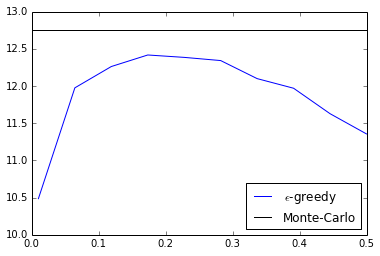

In [25]:
from matplotlib.pyplot import *
%matplotlib inline

plot(epsilon_vec, payoff_vec, label='$\epsilon$-greedy')
mm = AP_array[:,2].max()
hlines(mm,*xlim(), label='Monte-Carlo')
legend(loc='lower right')

For this parametrization of the problem, the optimal $\epsilon$ is approximately $0.2$. This means that one selects what is believed to be the best lever with probability 80%, while a random choice is made with probability 20%.

Note that here, the Monte-Carlo approach performs better than the $\epsilon$ greedy approach. However, no generalization should be made out of it.